In [51]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch
import torch.optim as optim


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
transform_train = transforms.Compose([ #composes several tranforms together
    transforms.RandomResizedCrop(224),   #input image-32x32.Resizing it to 224x224
    transforms.ToTensor(),             #converting the images to tensor
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))  #normalizing  the tensor
])

transform_test = transforms.Compose([ #composes several tranforms together
    transforms.RandomResizedCrop(224),   #input image-32x32.Resizing it to 224x224
    transforms.ToTensor(),             #converting the images to tensor
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))  #normalizing  the tensor
])

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data',train=True,transform=transform_train,download=True)
testset = torchvision.datasets.CIFAR10(root='./data',train=False,transform=transform_test,download=True)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
num_classes=10
batch_size=4

In [6]:
trainloader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)

In [7]:
dataiter =iter(trainloader)
images,labels=dataiter.next()

print(images.shape)

torch.Size([4, 3, 224, 224])


In [8]:
print(images[3].shape)
print(labels[3].item())

torch.Size([3, 224, 224])
2


In [9]:
def imshow(image,title):
  np_img = image.numpy()/2 + 0.5
  plt.figure(figsize=(batch_size,1))
  plt.axis('off')
  plt.imshow(np.transpose(np_img,(1,2,0)))
  plt.title(title)
  plt.show()

In [10]:
def show_batch_images(dataloader):
  images,labels=next(iter(dataloader))
  img = torchvision.utils.make_grid(images)
  imshow(img,title=[str(x.item()) for x in labels])

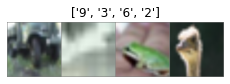

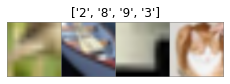

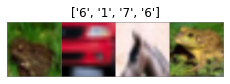

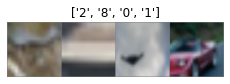

In [11]:
for i in range(4):
  show_batch_images(trainloader)

#VGG Network

In [12]:
from torchvision import models

In [13]:
vgg = models.vgg16_bn()

In [14]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [15]:
#changing the output classes to 10 instead of 64 in last(6) layer of classifier
final_in_features=vgg.classifier[6].in_features
mod_classifier = list(vgg.classifier.children())[:-1]
mod_classifier.extend([nn.Linear(final_in_features, num_classes)])
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=10, bias=True)]


In [16]:
#Adding the change in original vgg network
vgg.classifier=nn.Sequential(*mod_classifier)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

##Training CIFAR10 using vgn16

In [17]:
batch_size=16
trainloader=torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
testloader=torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False)

In [18]:
def evaluation(dataloader,model):
  total,correct=0,0
  for data in dataloader:
    inputs,labels= data
    inputs,labels= inputs.to(device),labels.to(device)
    outputs=model(inputs)
    _,pred=torch.max(outputs,1)
    total += labels.size(0)
    correct += (pred==labels).sum().item()
    return 100*correct/total


  

In [19]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(),lr=0.04)


Iteration: 0/3125, Loss: 2.39
Iteration: 100/3125, Loss: 2.50
Iteration: 200/3125, Loss: 2.14
Iteration: 300/3125, Loss: 2.08
Iteration: 400/3125, Loss: 2.14
Iteration: 500/3125, Loss: 2.11
Iteration: 600/3125, Loss: 2.34
Iteration: 700/3125, Loss: 2.22
Iteration: 800/3125, Loss: 2.13
Iteration: 900/3125, Loss: 1.81
Iteration: 1000/3125, Loss: 2.03
Iteration: 1100/3125, Loss: 2.14
Iteration: 1200/3125, Loss: 2.01
Iteration: 1300/3125, Loss: 1.77
Iteration: 1400/3125, Loss: 2.08
Iteration: 1500/3125, Loss: 2.56
Iteration: 1600/3125, Loss: 2.44
Iteration: 1700/3125, Loss: 2.14
Iteration: 1800/3125, Loss: 2.40
Iteration: 1900/3125, Loss: 1.89
Iteration: 2000/3125, Loss: 2.02
Iteration: 2100/3125, Loss: 1.94
Iteration: 2200/3125, Loss: 1.99
Iteration: 2300/3125, Loss: 2.28
Iteration: 2400/3125, Loss: 2.12
Iteration: 2500/3125, Loss: 1.58
Iteration: 2600/3125, Loss: 1.86
Iteration: 2700/3125, Loss: 1.87
Iteration: 2800/3125, Loss: 2.19
Iteration: 2900/3125, Loss: 2.06
Iteration: 3000/3125, 

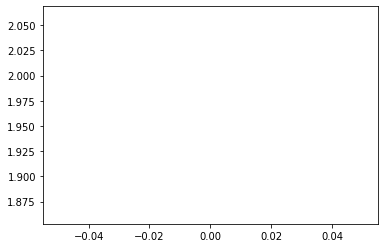

In [20]:
loss_array=[]
max_epochs=1
n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):
  for i,data in enumerate(trainloader,0):
    inputs,labels = data
    inputs,labels = inputs.to(device),labels.to(device)

    opt.zero_grad()

    outputs=vgg(inputs)
    loss=loss_fn(outputs,labels)
    loss.backward()
    opt.step()

    del inputs,labels,outputs
    torch.cuda.empty_cache()

    if (i%100)==0:
      print("Iteration: %d/%d, Loss: %0.2f" % (i, n_iters, loss.item()))

    
  loss_array.append(loss.item())
        
  print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, vgg), evaluation(trainloader, vgg)))
    
plt.plot(loss_array)


###Inference : The time taken to train a completely new model takes a long time for a epoch. Although the model started with a considerable loss value ,along its path,at further iteration loss value tends to increase rather than decreasing . So we have load a neural network model which is already pretrained for a different dataset and plug in that in our area of interest


##freezing layers of convolution operation

In [21]:
batch_size=16
trainloader =torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
testloader=torch.utils.data.DataLoader(testset,batch_size=batch_size,shuffle=False)


In [22]:
vgg=models.vgg16_bn(pretrained=True)  #Loading a vgg model which pretrained already

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


In [23]:
for param in vgg.parameters():
  param.requires_grad=False

In [24]:
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, num_classes)

In [25]:
for param in vgg.parameters():
  if param.requires_grad:
    print(param.shape)

torch.Size([10, 4096])
torch.Size([10])


In [26]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

Iteration: 0/3125, Loss: 2.40
Iteration: 100/3125, Loss: 1.76
Iteration: 200/3125, Loss: 2.22
Iteration: 300/3125, Loss: 1.44
Iteration: 400/3125, Loss: 1.81
Iteration: 500/3125, Loss: 1.27
Iteration: 600/3125, Loss: 1.55
Iteration: 700/3125, Loss: 2.43
Iteration: 800/3125, Loss: 2.40
Iteration: 900/3125, Loss: 1.99
Iteration: 1000/3125, Loss: 1.89
Iteration: 1100/3125, Loss: 1.15
Iteration: 1200/3125, Loss: 1.29
Iteration: 1300/3125, Loss: 1.96
Iteration: 1400/3125, Loss: 2.01
Iteration: 1500/3125, Loss: 2.26
Iteration: 1600/3125, Loss: 2.73
Iteration: 1700/3125, Loss: 1.50
Iteration: 1800/3125, Loss: 2.89
Iteration: 1900/3125, Loss: 3.20
Iteration: 2000/3125, Loss: 1.91
Iteration: 2100/3125, Loss: 0.83
Iteration: 2200/3125, Loss: 0.94
Iteration: 2300/3125, Loss: 2.45
Iteration: 2400/3125, Loss: 1.46
Iteration: 2500/3125, Loss: 2.01
Iteration: 2600/3125, Loss: 2.65
Iteration: 2700/3125, Loss: 2.50
Iteration: 2800/3125, Loss: 1.20
Iteration: 2900/3125, Loss: 2.38
Iteration: 3000/3125, 

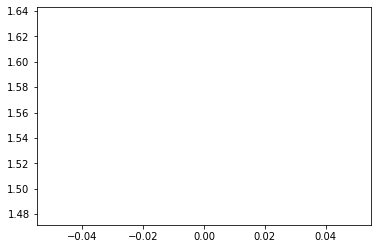

In [27]:
max_epoch=1
loss_arr = []

n_iters = np.ceil(50000/batch_size)
for epoch in range(max_epochs):
  for i,data in enumerate(trainloader,0):
    inputs,labels = data
    inputs,labels = inputs.to(device),labels.to(device)

    opt.zero_grad()

    outputs = vgg(inputs)
    loss=loss_fn(outputs,labels)
    loss.backward()
    opt.step()
    if i % 100 == 0:
      print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
    del inputs, labels, outputs
    torch.cuda.empty_cache()

  loss_arr.append(loss.item())
        
  print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, vgg), evaluation(trainloader, vgg)))
  
plt.plot(loss_arr)
plt.show()


##with model copies

In [28]:
import copy

In [29]:
max_epoch=1
loss_arr = []
min_loss=1000

n_iters = np.ceil(50000/batch_size)
for epoch in range(max_epochs):
  for i,data in enumerate(trainloader,0):
    inputs,labels = data
    inputs,labels = inputs.to(device),labels.to(device)

    opt.zero_grad()

    outputs = vgg(inputs)
    loss=loss_fn(outputs,labels)
    loss.backward()
    opt.step()

    if min_loss > loss.item(): # copying the model which has the least loss value
      min_loss=loss.item()
      best_model = copy.deepcopy(vgg.state_dict())
      print('Min loss %0.2f' % min_loss)

    if i % 100 == 0:
      print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
    del inputs, labels, outputs
    torch.cuda.empty_cache()

  loss_arr.append(loss.item())

Min loss 2.45
Iteration: 0/3125, Loss: 2.45
Min loss 1.51
Min loss 1.48
Min loss 1.29
Min loss 1.23
Min loss 1.14
Iteration: 100/3125, Loss: 1.87
Min loss 1.06
Iteration: 200/3125, Loss: 3.60
Min loss 1.04
Min loss 0.92
Iteration: 300/3125, Loss: 1.73
Min loss 0.61
Iteration: 400/3125, Loss: 2.78
Iteration: 500/3125, Loss: 1.54
Iteration: 600/3125, Loss: 2.27
Iteration: 700/3125, Loss: 2.26
Iteration: 800/3125, Loss: 2.54
Iteration: 900/3125, Loss: 1.29
Iteration: 1000/3125, Loss: 1.86
Iteration: 1100/3125, Loss: 1.88
Iteration: 1200/3125, Loss: 2.44
Min loss 0.53
Iteration: 1300/3125, Loss: 1.70
Iteration: 1400/3125, Loss: 2.06
Iteration: 1500/3125, Loss: 2.79
Iteration: 1600/3125, Loss: 1.62
Iteration: 1700/3125, Loss: 1.49
Iteration: 1800/3125, Loss: 1.32
Iteration: 1900/3125, Loss: 3.06
Iteration: 2000/3125, Loss: 2.29
Iteration: 2100/3125, Loss: 2.56
Iteration: 2200/3125, Loss: 1.41
Iteration: 2300/3125, Loss: 2.52
Iteration: 2400/3125, Loss: 2.35
Iteration: 2500/3125, Loss: 2.02


In [30]:
vgg.load_state_dict(best_model)
print(evaluation(trainloader, vgg), evaluation(testloader, vgg))

56.25 68.75


#Resnet Model

In [31]:
resnet = models.resnet18(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [32]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [33]:
for params in resnet.parameters():
  params.requires_grad = False

In [34]:
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features,num_classes)

In [35]:
print(resnet.fc)

Linear(in_features=512, out_features=10, bias=True)


In [36]:
for params in resnet.parameters():
  if params.requires_grad:
    print(params.shape)

torch.Size([10, 512])
torch.Size([10])


In [37]:
resnet = resnet.to(device)

In [38]:
loss_fn = nn.CrossEntropyLoss()
optim = optim.SGD(resnet.parameters(),lr=0.02)

Min loss 2.47
Iteration: 0/3125, Loss: 2.47
Min loss 2.36
Min loss 2.25
Min loss 2.13
Iteration: 100/3125, Loss: 2.44
Iteration: 200/3125, Loss: 2.62
Min loss 2.05
Iteration: 300/3125, Loss: 2.81
Iteration: 400/3125, Loss: 2.30
Iteration: 500/3125, Loss: 2.78
Iteration: 600/3125, Loss: 2.33
Iteration: 700/3125, Loss: 2.38
Iteration: 800/3125, Loss: 2.51
Iteration: 900/3125, Loss: 2.41
Iteration: 1000/3125, Loss: 2.77
Min loss 2.00
Iteration: 1100/3125, Loss: 2.45
Iteration: 1200/3125, Loss: 2.57
Iteration: 1300/3125, Loss: 2.79
Iteration: 1400/3125, Loss: 2.44
Iteration: 1500/3125, Loss: 2.34
Iteration: 1600/3125, Loss: 2.47
Iteration: 1700/3125, Loss: 2.35
Iteration: 1800/3125, Loss: 2.60
Iteration: 1900/3125, Loss: 2.49
Iteration: 2000/3125, Loss: 2.18
Iteration: 2100/3125, Loss: 2.25
Iteration: 2200/3125, Loss: 2.31
Iteration: 2300/3125, Loss: 2.59
Iteration: 2400/3125, Loss: 2.72
Iteration: 2500/3125, Loss: 2.51
Iteration: 2600/3125, Loss: 2.35
Iteration: 2700/3125, Loss: 2.68
Iter

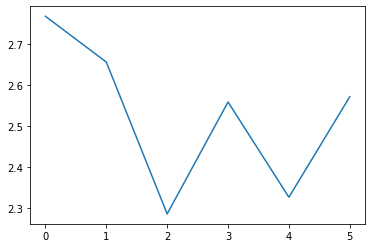

In [39]:
max_epochs=6
loss_arr =[]

n_iters=np.ceil(50000/batch_size)
min_loss=1000

for epoch in range(max_epochs):
  for i,data in enumerate(trainloader,0):
    inputs,labels = data
    inputs,labels = inputs.to(device),labels.to(device)
    opt.zero_grad()

    outputs=resnet(inputs)
    loss=loss_fn(outputs,labels)
    loss.backward()
    opt.step()
     
     
    if min_loss > loss.item():
       min_loss=loss.item()
       best_model = copy.deepcopy(resnet.state_dict())
       print('Min loss %0.2f' % min_loss)

    if (i%100==0):
       print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))

    del inputs,labels,outputs
    torch.cuda.empty_cache()

  loss_arr.append(loss.item())
  print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, resnet), evaluation(trainloader, resnet)))
  
plt.plot(loss_arr)
plt.show()




In [40]:
resnet.load_state_dict(best_model)
print(evaluation(trainloader,resnet),evaluation(testloader,resnet))


0.0 12.5


#Inception Model

In [41]:
inception = models.inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


In [42]:
print(inception)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [43]:
for params in inception.parameters():
  params.requires_grad= False

In [44]:
aux_in_features = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)

In [45]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 768])
torch.Size([10])


In [46]:
in_features = inception.fc.in_features
inception.fc = nn.Linear(in_features, num_classes)

In [47]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 768])
torch.Size([10])
torch.Size([10, 2048])
torch.Size([10])


In [56]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(299), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(299), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

In [57]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        download=True, 
                                        transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [59]:
batch_size=16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [60]:
inception = inception.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(inception.parameters(),lr=0.01)

In [61]:
def evaluation_inception(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, aux_outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

Min loss 3.12
Iteration: 0/3125, Loss: 3.12
Min loss 3.09
Min loss 3.05
Min loss 2.99
Min loss 2.93
Min loss 2.85
Min loss 2.82
Min loss 2.77
Min loss 2.73
Min loss 2.72
Min loss 2.68
Min loss 2.68
Min loss 2.58
Min loss 2.50
Min loss 2.41
Iteration: 100/3125, Loss: 2.72
Min loss 2.40
Min loss 2.38
Min loss 2.37
Min loss 2.15
Iteration: 200/3125, Loss: 2.32
Min loss 2.08
Min loss 2.06
Min loss 1.82
Iteration: 300/3125, Loss: 2.12
Iteration: 400/3125, Loss: 2.30
Min loss 1.76
Min loss 1.72
Iteration: 500/3125, Loss: 2.04
Iteration: 600/3125, Loss: 2.46
Min loss 1.69
Iteration: 700/3125, Loss: 2.49
Min loss 1.53
Iteration: 800/3125, Loss: 2.02
Iteration: 900/3125, Loss: 2.56
Min loss 1.53
Min loss 1.42
Iteration: 1000/3125, Loss: 2.08
Min loss 1.21
Iteration: 1100/3125, Loss: 2.32
Iteration: 1200/3125, Loss: 1.59
Iteration: 1300/3125, Loss: 2.03
Min loss 1.17
Iteration: 1400/3125, Loss: 1.99
Iteration: 1500/3125, Loss: 1.60
Iteration: 1600/3125, Loss: 1.82
Iteration: 1700/3125, Loss: 1.8

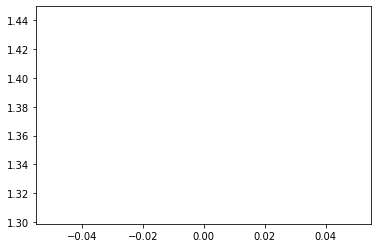

In [62]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs, aux_outputs = inception(inputs)
        loss = loss_fn(outputs, labels) + 0.3 * loss_fn(aux_outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(inception.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation_inception(testloader, inception), 
        evaluation_inception(trainloader, inception)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

In [63]:
inception.load_state_dict(best_model)
print(evaluation_inception(trainloader, inception), evaluation_inception(testloader, inception))

46.464 47.22
